### **Amazon Example for Class**

![](https://images-eu.ssl-images-amazon.com/images/G/30/Consumables/Beauty/2023/header.png)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN, SVD
from matplotlib.cbook import boxplot_stats

In [2]:
import os
import sys
import time
import math
import torch
import cornac
import warnings
import operator
import itertools
import scipy.stats
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import scipy.sparse as sp
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data

from tabulate import tabulate
from cornac.utils import cache
from sklearn.manifold import TSNE
from adjustText import adjust_text
from collections import defaultdict
from scipy.sparse.linalg import svds
from torch.utils.data import Dataset
from numpy.linalg import matrix_rank
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
#from recommenders.utils.timer import Timer
#from recommenders.datasets import movielens
#from recommenders.utils.constants import SEED
from sklearn.metrics import mean_squared_error
from elasticsearch import Elasticsearch, helpers
from sklearn.metrics.pairwise import cosine_similarity
from cornac.models import MF, NMF, BaselineOnly, BPR, WMF
#from recommenders.utils.notebook_utils import store_metadata
#from recommenders.models.cornac.cornac_utils import predict_ranking
#from recommenders.datasets.python_splitters import python_random_split
#from recommenders.evaluation.python_evaluation import (
#    map,
#    ndcg_at_k,
#    precision_at_k,
#    recall_at_k,
#)

#### **0. EDA**

In [3]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings.drop('Timestamp', axis=1, inplace=True)
amazon_ratings.head()

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


In [4]:
# ? - Extract the usefful information and get info 
amazon_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


In [5]:
amazon_ratings.isna().sum() # ? - Preprocessed null values 

UserId       0
ProductId    0
Rating       0
dtype: int64

In [6]:
amazon_ratings.value_counts('Rating', normalize= True) 
# ? - Percentage of rating distributions
# ? - We observe that there is an excess proportion of high star ranking. 

Rating
5.0    0.617241
4.0    0.152115
1.0    0.090844
3.0    0.083927
2.0    0.055873
Name: proportion, dtype: float64

In [7]:
# ? - Unique counts 
df = amazon_ratings

unique_counts = df.nunique() # ? - Get the unique values for the dataset in case of duplicates 
unique_values = [df[column].unique() for column in df.columns]
data_types = [str(amazon_ratings[column].dtype) for column in amazon_ratings.columns] 
# ? - Display the data information in a table, with unique values, probably to get the shape
unique_counts_df = pd.DataFrame({'feature': amazon_ratings.columns, 'unique_count':unique_counts, 'unique_values':unique_values, 'data_types':data_types})
unique_counts_df

,feature,unique_count,unique_values,data_types
UserId,UserId,1210271,"[A39HTATAQ9V7YF, A3JM6GV9MNOF9X, A1Z513UWSAAO0...",object
ProductId,ProductId,249274,"[0205616461, 0558925278, 0733001998, 073710447...",object
Rating,Rating,5,"[5.0, 3.0, 4.0, 1.0, 2.0]",float64


In [8]:
amazon_ratings_sample = amazon_ratings.sample(10000, random_state= 23, ignore_index=True)
amazon_ratings_sample.head()

,UserId,ProductId,Rating
0,A28NETRZZGNQNN,B001GIOV8C,5.0
1,A3V2Z5651OC7R8,B001E6P6MQ,4.0
2,A2D8W4WA9YELPE,B00B4D8XUQ,4.0
3,A1RLQXYNCMWRWN,B004FJHEHY,5.0
4,A2JED4KXRSWSA,B000FGC99O,1.0


In [9]:
n_users = amazon_ratings['UserId'].nunique()
print('Number of unique users:', n_users)
n_items = amazon_ratings['ProductId'].nunique()
print('Number of unique products:', n_items)

Number of unique users: 1210271
Number of unique products: 249274


Function to find outliers in any dataset for input columns: 

In [10]:
# ? - For numeric variables, plot all box plots
def explore_outliers(df, num_var): 
    """
    For each variable defined, plot a boxplot, of the variable to observe possible outliers. 
    Fill in the dataframe dictionary with the rating values, 
    
    """
    outliers_df = {}
    for k in range(len(num_var)): 
        var = num_var[k]
        sns.boxplot(data=df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0]['fliers'] # ? - Structure of all the output is the mean, iqr, etc... fliers are the anomalies
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist()
        out_idx = [df[var].index.tolist()[ k ] for k in out_pos]
        outliers_df[var] = {'values':outliers_df[var], 
                            'positions': out_pos, 
                            'indices': out_idx}
    return outliers_df

In [11]:
boxplot_stats(amazon_ratings_sample['Rating'])

[{'mean': 4.1523,
  'iqr': 1.0,
  'cilo': 4.9843,
  'cihi': 5.0157,
  'whishi': 5.0,
  'whislo': 3.0,
  'fliers': array([1., 2., 1., ..., 1., 1., 2.]),
  'q1': 4.0,
  'med': 5.0,
  'q3': 5.0}]

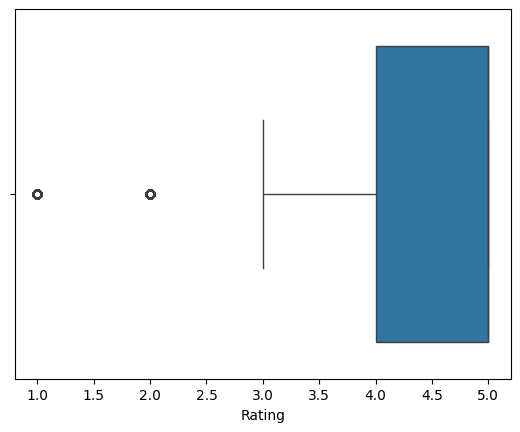

In [12]:
outliers_ratings = explore_outliers(amazon_ratings_sample, ['Rating'])

In [13]:
boxplot_data = pd.DataFrame(outliers_ratings)
boxplot_data

,Rating
values,"[1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, ..."
positions,"[4, 6, 14, 16, 17, 45, 52, 61, 80, 84, 86, 94,..."
indices,"[4, 6, 14, 16, 17, 45, 52, 61, 80, 84, 86, 94,..."


In [14]:
outliers_ratings

{'Rating': {'values': array([1., 2., 1., ..., 1., 1., 2.]),
  'positions': [4,
   6,
   14,
   16,
   17,
   45,
   52,
   61,
   80,
   84,
   86,
   94,
   111,
   118,
   129,
   148,
   150,
   153,
   158,
   159,
   177,
   178,
   181,
   189,
   194,
   196,
   202,
   209,
   210,
   221,
   227,
   229,
   240,
   241,
   249,
   256,
   259,
   277,
   278,
   281,
   282,
   286,
   293,
   298,
   311,
   330,
   336,
   341,
   357,
   367,
   368,
   374,
   376,
   380,
   392,
   403,
   410,
   414,
   429,
   430,
   449,
   453,
   458,
   463,
   465,
   477,
   483,
   484,
   495,
   501,
   503,
   508,
   511,
   513,
   535,
   543,
   569,
   574,
   580,
   583,
   598,
   601,
   605,
   607,
   608,
   613,
   621,
   649,
   651,
   652,
   655,
   661,
   673,
   675,
   681,
   684,
   687,
   691,
   692,
   697,
   715,
   728,
   739,
   743,
   764,
   775,
   795,
   811,
   819,
   825,
   829,
   838,
   840,
   842,
   852,
   857,
   858,
   86

In [15]:
print(f'Percentage of outliers: {round(len(outliers_ratings.get('Rating').get('indices'))/len(amazon_ratings_sample), 3)*100} %')
# ? - Okay so this gets the number of elements and then divides it by the total length of the sample

Percentage of outliers: 14.6 %


## QUESTION: SHOULD WE DROP THE OUTLIERS?

In this case no, since the rating histogram is to left-skewed and we wish to capture all behaviours. 
In case of a more symetrical distribution we could remove them 

In [16]:
# ? - If it's in our interest to drop the anomalies we would do so like: 
#!amazon_ratings_sample.drop(outliers_ratings.get('Rating').get('indices'), inplace=True)

In [17]:
amazon_ratings_sample

,UserId,ProductId,Rating
0,A28NETRZZGNQNN,B001GIOV8C,5.0
1,A3V2Z5651OC7R8,B001E6P6MQ,4.0
2,A2D8W4WA9YELPE,B00B4D8XUQ,4.0
3,A1RLQXYNCMWRWN,B004FJHEHY,5.0
4,A2JED4KXRSWSA,B000FGC99O,1.0
...,...,...,...
9995,A16FOR0MC105DU,B005OTEH3S,5.0
9996,A2K91UAW4XC13A,B006DR2BO2,5.0
9997,A14F40N1TXC0TS,B001EWF2B0,5.0
9998,A4BIDFGYHF28C,B00011QVIS,5.0


In [18]:

# ? - Now that our EDA is complete, let's build the ratings matrix: 
ratings_matrix = amazon_ratings_sample.pivot_table(
    index="UserId",
    columns="ProductId",
    values="Rating",
)
ratings_matrix.head()

ProductId,1451646526,4057553908,753865058X,9788073409,9788080669,9790771584,9790778309,979079035X,9790790961,B00004TMFE,...,B00KAL5JAU,B00KD73PBQ,B00KECCJTY,B00KHH2VOY,B00KIWJ1W8,B00KNCUMDU,B00KQVTX06,B00KWE08Q0,B00L3KEIZO,B00LCLFMDG
UserId,,,,,,,,,,,,,,,,,,,,,
A00407141VL6SB77B1GGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0056746VLX0I5VJCFN6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05198112VVJ1HUQ3SWU5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05510841IANN1R9RQYTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Mean Rating', ylabel='Count'>

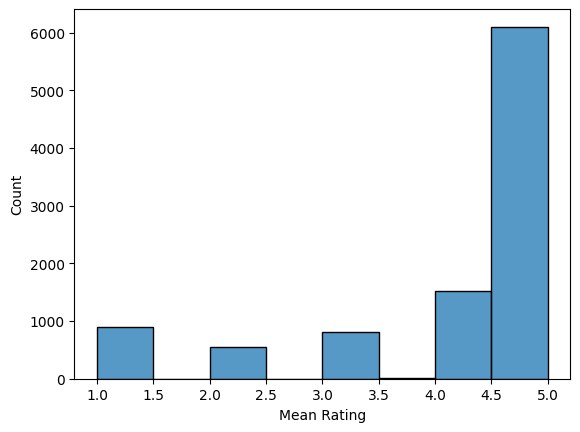

In [19]:
df = ratings_matrix
df['Mean Rating'] = df.mean(axis=1) # ? - Get the mean score for each user 
sns.histplot(x = 'Mean Rating', binwidth=0.5, data=df)

# Long tail visualization: 
Calculate the num. of missing values over the total num of possible matrix values. High sparsity indicates most user-item pairs lack interactions. Making it challenging to predict preferences. Low sparsity is better :) 

In [20]:
def print_sparsity(df):
  n_users = df.UserId.nunique()
  n_items = df.ProductId.nunique()
  n_ratings = len(df)
  rating_matrix_size = n_users * n_items
  sparsity = 1 - n_ratings / rating_matrix_size

  print(f"Number of users: {n_users}")
  print(f"Number of items: {n_items}")
  print(f"Number of available ratings: {n_ratings}")
  print(f"Number of all possible ratings: {rating_matrix_size}")
  print("-" * 40)
  print(f"SPARSITY: {sparsity * 100.0:.2f}%")

print_sparsity(amazon_ratings_sample)

Number of users: 9898
Number of items: 8132
Number of available ratings: 10000
Number of all possible ratings: 80490536
----------------------------------------
SPARSITY: 99.99%


In [21]:
df.head() # * ah claro que aparece vacía, si la mayoría no tienen rating 

ProductId,1451646526,4057553908,753865058X,9788073409,9788080669,9790771584,9790778309,979079035X,9790790961,B00004TMFE,...,B00KD73PBQ,B00KECCJTY,B00KHH2VOY,B00KIWJ1W8,B00KNCUMDU,B00KQVTX06,B00KWE08Q0,B00L3KEIZO,B00LCLFMDG,Mean Rating
UserId,,,,,,,,,,,,,,,,,,,,,
A00407141VL6SB77B1GGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
A0056746VLX0I5VJCFN6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
A05198112VVJ1HUQ3SWU5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A05510841IANN1R9RQYTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [22]:
item_rate_count = amazon_ratings_sample.groupby('ProductId')['UserId'].nunique().sort_values(ascending=False)
item_rate_count # ? - Get the number of reviews for a product

ProductId
B001MA0QY2    40
B004OHQR1Q    13
B0009V1YR8    12
B000FS05VG    11
B003S516XO    10
              ..
B001Q8560Y     1
B001Q508GY     1
B001Q3I462     1
B001PTFXR0     1
B00LCLFMDG     1
Name: UserId, Length: 8132, dtype: int64

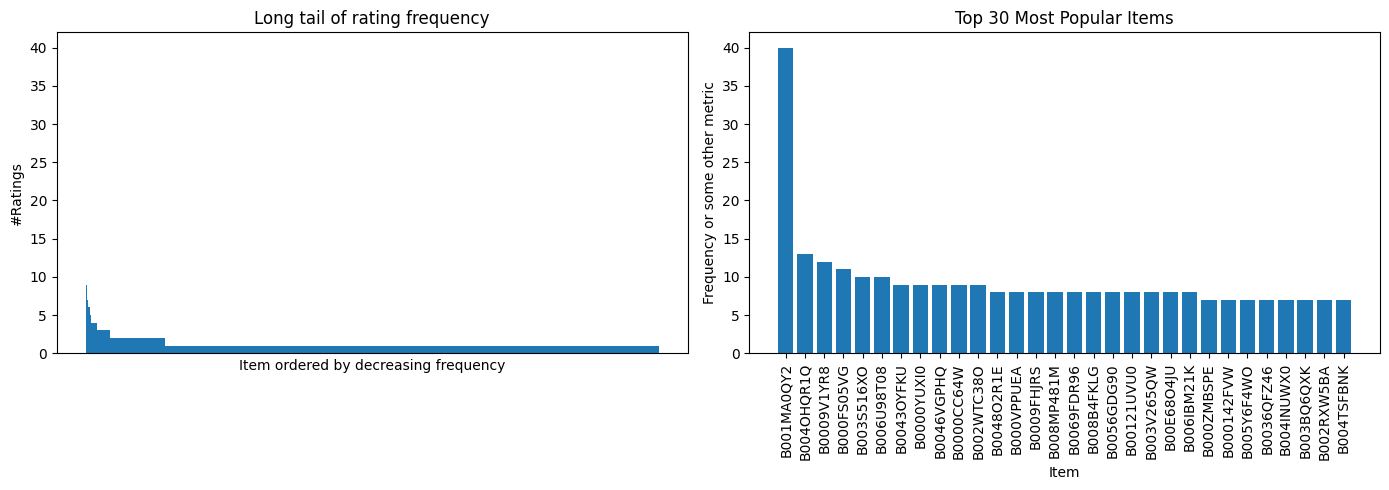

In [23]:
popular_products = pd.DataFrame(amazon_ratings_sample.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# First plot
axes[0].bar(x=range(len(item_rate_count)), height=item_rate_count.values, width=5.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="Long tail of rating frequency", 
            xlabel="Item ordered by decreasing frequency", 
            ylabel="#Ratings")

# Second plot adaptation
# Assuming most_popular is a Series. If it's a DataFrame, you might need to adjust this part.
x_pos = range(len(most_popular.head(30))) # Generate x positions
axes[1].bar(x=x_pos, height=most_popular.head(30)['Rating'], align="center")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(most_popular.head(30).index, rotation='vertical')
axes[1].set(title="Top 30 Most Popular Items", 
            xlabel="Item", 
            ylabel="Frequency or some other metric")

plt.tight_layout()
plt.show()

#### **1. User-based recommendation**

In [24]:
ratings_matrix

ProductId,1451646526,4057553908,753865058X,9788073409,9788080669,9790771584,9790778309,979079035X,9790790961,B00004TMFE,...,B00KD73PBQ,B00KECCJTY,B00KHH2VOY,B00KIWJ1W8,B00KNCUMDU,B00KQVTX06,B00KWE08Q0,B00L3KEIZO,B00LCLFMDG,Mean Rating
UserId,,,,,,,,,,,,,,,,,,,,,
A00407141VL6SB77B1GGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
A0056746VLX0I5VJCFN6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
A05198112VVJ1HUQ3SWU5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A05510841IANN1R9RQYTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZXZJMSR6FNAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
AZY5X93OVEWO7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
AZYJE40XW6MFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [25]:
normalised_ratings_matrix = ratings_matrix.subtract(ratings_matrix.mean(axis=1), axis =0) # * We could call this mean centered

In [26]:
def userknn_cornac(df:pd.DataFrame):

  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors 
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_300 = cornac.metrics.Recall(k=300)
  rec_900 = cornac.metrics.Recall(k=900)
  prec_30 = cornac.metrics.Precision(k=30)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_300, rec_900, prec_30, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

userknn_models = userknn_cornac(amazon_ratings_sample)


TEST:
...
                   |    MAE |   RMSE | Precision@30 | Recall@300 | Recall@900 | Train (s) | Test (s)
------------------ + ------ + ------ + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 1.1250 | 1.1250 |       0.0000 |     0.0000 |     0.1250 |    0.4200 |   0.1286
UserKNN-Cosine-MC  | 1.1250 | 1.1250 |       0.0000 |     0.0000 |     0.1250 |    0.3833 |   0.1249
UserKNN-Pearson    | 1.1250 | 1.1250 |       0.0000 |     0.0000 |     0.1250 |    0.3829 |   0.1129
UserKNN-Pearson-MC | 1.1250 | 1.1250 |       0.0000 |     0.0000 |     0.1250 |    0.3803 |   0.1346



In [27]:
item_similarity_cosine = cosine_similarity(normalised_ratings_matrix.fillna(0))

### User-profiling

In [28]:
df_user_10k = pd.read_csv('ratings_Beauty.csv').set_index('UserId').drop('Timestamp', axis=1)
df_item_10k = pd.read_csv('ratings_Beauty.csv').set_index('ProductId').drop('Timestamp', axis=1)

In [29]:
df_user_10k

,ProductId,Rating
UserId,,
A39HTATAQ9V7YF,0205616461,5.0
A3JM6GV9MNOF9X,0558925278,3.0
A1Z513UWSAAO0F,0558925278,5.0
A1WMRR494NWEWV,0733001998,4.0
A3IAAVS479H7M7,0737104473,1.0
...,...,...
A3DEHKPFANB8VA,B00LORWRJA,5.0
A3DEHKPFANB8VA,B00LOS7MEE,5.0
AG9TJLJUN5OM3,B00LP2YB8E,5.0


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

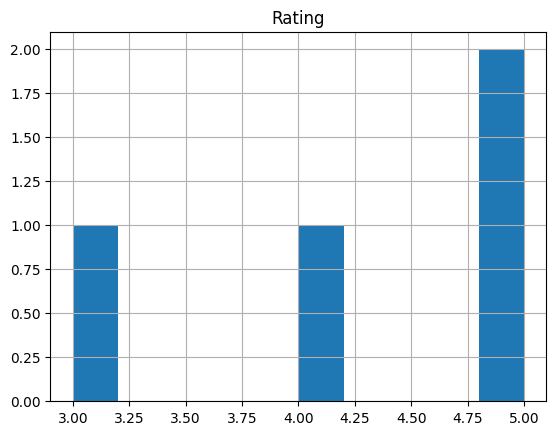

In [30]:
df_user_10k.loc['A39HTATAQ9V7YF'].hist()

In [31]:
users = df_item_10k.groupby('UserId') # ? - Get product list per reviewer.
items = df_user_10k.groupby('ProductId') # ? - Get reviewer list per product.
users.get_group('A39HTATAQ9V7YF') # ? - Select the product ratings for a specific user. 
items.get_group('B002OVV7F0')

,ProductId,Rating
UserId,,
A20NUABVL6KKTV,B002OVV7F0,4.0
AET0G8IGXJ4HB,B002OVV7F0,1.0
A39B0OLY1BW17P,B002OVV7F0,5.0
A1N5YSOJ8LVE3K,B002OVV7F0,5.0
AC1SYIKNP5D9W,B002OVV7F0,4.0
...,...,...
A2H4CCZCB7WJQK,B002OVV7F0,5.0
A01290231HW9YARUTSI41,B002OVV7F0,5.0
A1JSJDQ0HY7N26,B002OVV7F0,4.0


In [32]:
def user_profiling(UID, model, user_df, TOPK=5):

  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.uid_map.items())[UID][0]

  print(f"UserID = {UIDX}")
  print("-" * 35)
  print(user_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  user_ratings = ratings.loc[UID]
  top_rated_items = np.argsort(user_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
  print("-" * 35)
  print(user_df.iloc[top_rated_items.array])

In [33]:
 #! We pick our model - careful with the dashes: 
model = userknn_models.get('uknn_cosine_mc')
top_rated_items = user_profiling(8, model, df_user_10k)

UserID = A1MA7KAZCFKSZV
-----------------------------------
                 ProductId  Rating
UserId                            
A1MA7KAZCFKSZV  B000ALBLXE     5.0
A1MA7KAZCFKSZV  B000ALBLZ2     5.0
A1MA7KAZCFKSZV  B001G7PNDK     3.0
A1MA7KAZCFKSZV  B0041ZLOPU     5.0

TOP 5 RATED ITEMS BY USER 8:
-----------------------------------
                 ProductId  Rating
UserId                            
A2EGBFPY941PAB  9879870743     5.0
A3EEV0HQ8WC1J6  9879870743     5.0
A2LAZHBNMJW82S  9896009651     5.0
AQXR5XB3URGK9   B000052YKM     5.0
A3V3RE4132GKRO  130414089X     5.0


**Score prediction for any given item:**

In [34]:
def uknn_get_scores(UID, model, user_df, TOPK=5):

    UIDX = list(model.train_set.uid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(user_df.iloc[recommendations[:TOPK]])

In [35]:
uknn_get_scores(2, model, df_user_10k)


TOP 5 RECOMMENDATIONS FOR USER A9QUSEMHTXYTA:
Scores: [3.00000001 3.         3.         3.         3.        ]
                 ProductId  Rating
UserId                            
A1Z513UWSAAO0F  0558925278     5.0
AQXR5XB3URGK9   B000052YKM     5.0
A2LAZHBNMJW82S  9896009651     5.0
A3EEV0HQ8WC1J6  9879870743     5.0
A2EGBFPY941PAB  9879870743     5.0


#### **2. Item-based**

In [36]:
def itemknn_cornac(df):
  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 50  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE)
  iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE)
  iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE)
  iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE)

  # Metrics
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()

  ratio_split = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
                    metrics=[rmse, mae],
                    ).run()
  itemknn_models = {'iknn_cosine': iknn_cosine, 'iknn_pearson': iknn_pearson,
                'iknn_pearson_mc': iknn_pearson_mc, 'iknn_adjusted': iknn_adjusted}
  return itemknn_models

In [37]:
itemknn_models = itemknn_cornac(amazon_ratings_sample)


TEST:
...
                       |    MAE |   RMSE | Train (s) | Test (s)
---------------------- + ------ + ------ + --------- + --------
ItemKNN-Cosine         | 1.1250 | 1.1250 |    0.3209 |   0.0019
ItemKNN-Pearson        | 1.1250 | 1.1250 |    0.3554 |   0.0010
ItemKNN-Pearson-MC     | 1.1250 | 1.1250 |    0.3242 |   0.0016
ItemKNN-AdjustedCosine | 1.1250 | 1.1250 |    0.2819 |   0.0015



In [38]:
def item_profiling(UID, model, item_df, TOPK=5):

  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.iid_map.items())[UID][0]

  print(f"ProductID = {UIDX}")
  print("-" * 35)
  print(item_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  item_ratings = ratings.iloc[UID]
  top_rated_items = np.argsort(item_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RECOMMENDED USERS FOR ITEM {UID}:")
  print("-" * 35)
  print(df_item_10k.iloc[top_rated_items.array])

In [39]:
model = itemknn_models.get('iknn_adjusted')

In [40]:
top_rated_items = item_profiling(2, model, df_item_10k)

ProductID = B0011GD5CM
-----------------------------------
                    UserId  Rating
ProductId                         
B0011GD5CM  A11RU2YNML78P1     5.0
B0011GD5CM  A1POFYCQ9096DU     5.0
B0011GD5CM  A2UO3JTBIQV1UM     5.0
B0011GD5CM  A2WBFDC7SDHPT6     5.0
B0011GD5CM   AFEU4FI71UYNJ     5.0
B0011GD5CM  A3QV0ZJJ7R8R91     5.0
B0011GD5CM     AZP9Z4R8JKE     5.0
B0011GD5CM   A9QUSEMHTXYTA     3.0
B0011GD5CM  A1NX16398HCGX1     5.0
B0011GD5CM   A8RIPCG68GRZN     5.0
B0011GD5CM   A1PO9TVZO5BOV     1.0

TOP 5 RECOMMENDED USERS FOR ITEM 2:
-----------------------------------
                    UserId  Rating
ProductId                         
9879870743  A2EGBFPY941PAB     5.0
9879870743  A3EEV0HQ8WC1J6     5.0
9896009651  A2LAZHBNMJW82S     5.0
B000052YKM   AQXR5XB3URGK9     5.0
0558925278  A1Z513UWSAAO0F     5.0


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

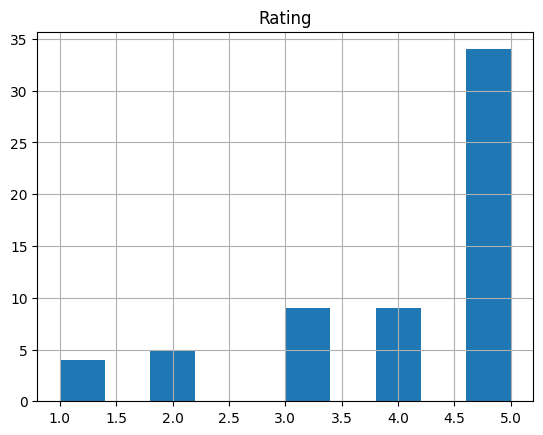

In [41]:
df_item_10k.loc['B0050QLE4U'].hist()

In [42]:
def itemknn_get_scores(UID, model, item_df, TOPK=5):

    UIDX = list(model.train_set.iid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} USERS FOR ITEM {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(item_df.iloc[recommendations[:TOPK]])

In [43]:
itemknn_get_scores(3, model, df_item_10k)


TOP 5 USERS FOR ITEM B008YKNHN0:
Scores: [5.00000001 5.         5.         5.         5.        ]
                    UserId  Rating
ProductId                         
0733001998  A1WMRR494NWEWV     4.0
B000052YKM   AQXR5XB3URGK9     5.0
9896009651  A2LAZHBNMJW82S     5.0
9879870743  A3EEV0HQ8WC1J6     5.0
9879870743  A2EGBFPY941PAB     5.0


#### **3. Model-Based**

**3.1 SVD**

In [44]:
ratings_matrix
mean_rating = 2.5 

r = ratings_matrix.fillna(mean_rating)
r = r.to_numpy()

# ? Center the ratings 
user_ratings_mean = np.mean(r, axis = 1)
r_centered = r - user_ratings_mean.reshape(-1, 1)

print(r.shape)
print(np.count_nonzero(r))

(9898, 8133)
80500434


In [45]:
u, sigma, v_T = svds(r_centered, k=50)  # Limit to the top 50 components
sigma = np.diag(sigma)
matrix_rank(r_centered)  # * To assess the max. number of latent vectors.

latents = [3, 10, 20, 30, 40, 50, 150, 300]
rmse_errors = []
for latent_dim in latents:
    U, sigma, v_T = svds(r_centered, k=latent_dim)
    sigma = np.diag(sigma)  # ? Force it to be diagonal
    # ? - Reconstruction of the matrix y_app = U*Sigma*Vt + user_mean (We could also add the item mean)
    r_pred = np.dot(np.dot(U, sigma), v_T) + user_ratings_mean.reshape(-1, 1)
    r_pred[r_pred < 0] = 0
    r_pred[r_pred > 5] = 5
    mse = np.square(np.subtract(r, r_pred)).mean  # ? - MSE formula
    rmse = math.sqrt(mse)
    rmse_errors.append(rmse)  # * Add it to the list

TypeError: must be real number, not builtin_function_or_method

In [ ]:
# ? - Plot opcional para observar como progresa el SVD
# ? - Hacemos ahí un elbow method supongo.
# TODO: Determinar si se debe de escoger un threshold
plt.xlabel("Latent Dimension")
plt.ylabel("RMSE")
plt.plot(latents, rmse_errors, "o-")
plt.show()

In [ ]:
r_pred_df = pd.DataFrame(r_pred)
r_pred.head()

# * Ways to get all of the recommendations at once by constructing the full matrix
# Y = U Sigma Vt + mean
all_user_predicted_ratings = np.dot(np.dot(u, sigma), v_T) + user_ratings_mean.reshape(
    -1, 1
)
all_user_predicted_ratings[all_user_predicted_ratings < 0] = 0
all_user_predicted_ratings[all_user_predicted_ratings > 5] = 5

In [ ]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=r.columns)
preds_df.head()

In [ ]:
def recommend_products(
        preds_df, userId, items_df , ratings_matrix, num_recommendations = 5
): 
    user_row_num = userId - 1
    sorted_user_pre

**3.2. Matrix Factorisation**

**3.3 KMeans for any model**

#### **4. Conclusions and Comparisons**